<a href="https://colab.research.google.com/github/pachterlab/gget_examples/blob/main/gget_elm_IUPred3_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Filter results returned by `gget.elm` using the [IUPred3](https://iupred.elte.hu/) API
This tutorial shows how results returned by `gget.elm` can be filtered based on IUPred scores to identify disordered protein regions.

Install and import software:

In [1]:
!pip install -qU gget

import gget
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.2/25.2 MB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Download the ELM database for use with `gget.elm`:

In [2]:
gget.setup("elm")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 36919  100 36919    0     0  66898      0 --:--:-- --:--:-- --:--:-- 66882
100 87336  100 87336    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  914k  100  914k    0     0   533k      0  0:00:01

Get IUPred scores for a UniProt Accession:

In [3]:
# Define the UniProt Accession
uniprot_acc = "P04637"

# Define IUPred type ("long" or "short")
disorder = "long"

In [4]:
# Get IUPred2 scores using the IUPred3 API
url = f"http://iupred3.elte.hu/iupred3/{disorder}/{uniprot_acc}.json"

r = requests.get(url)
r.status_code

200

Plot the IUPred2 scores (residues with a predicted score above 0.5 are considered disordered, while residues with lower scores considered to be ordered):

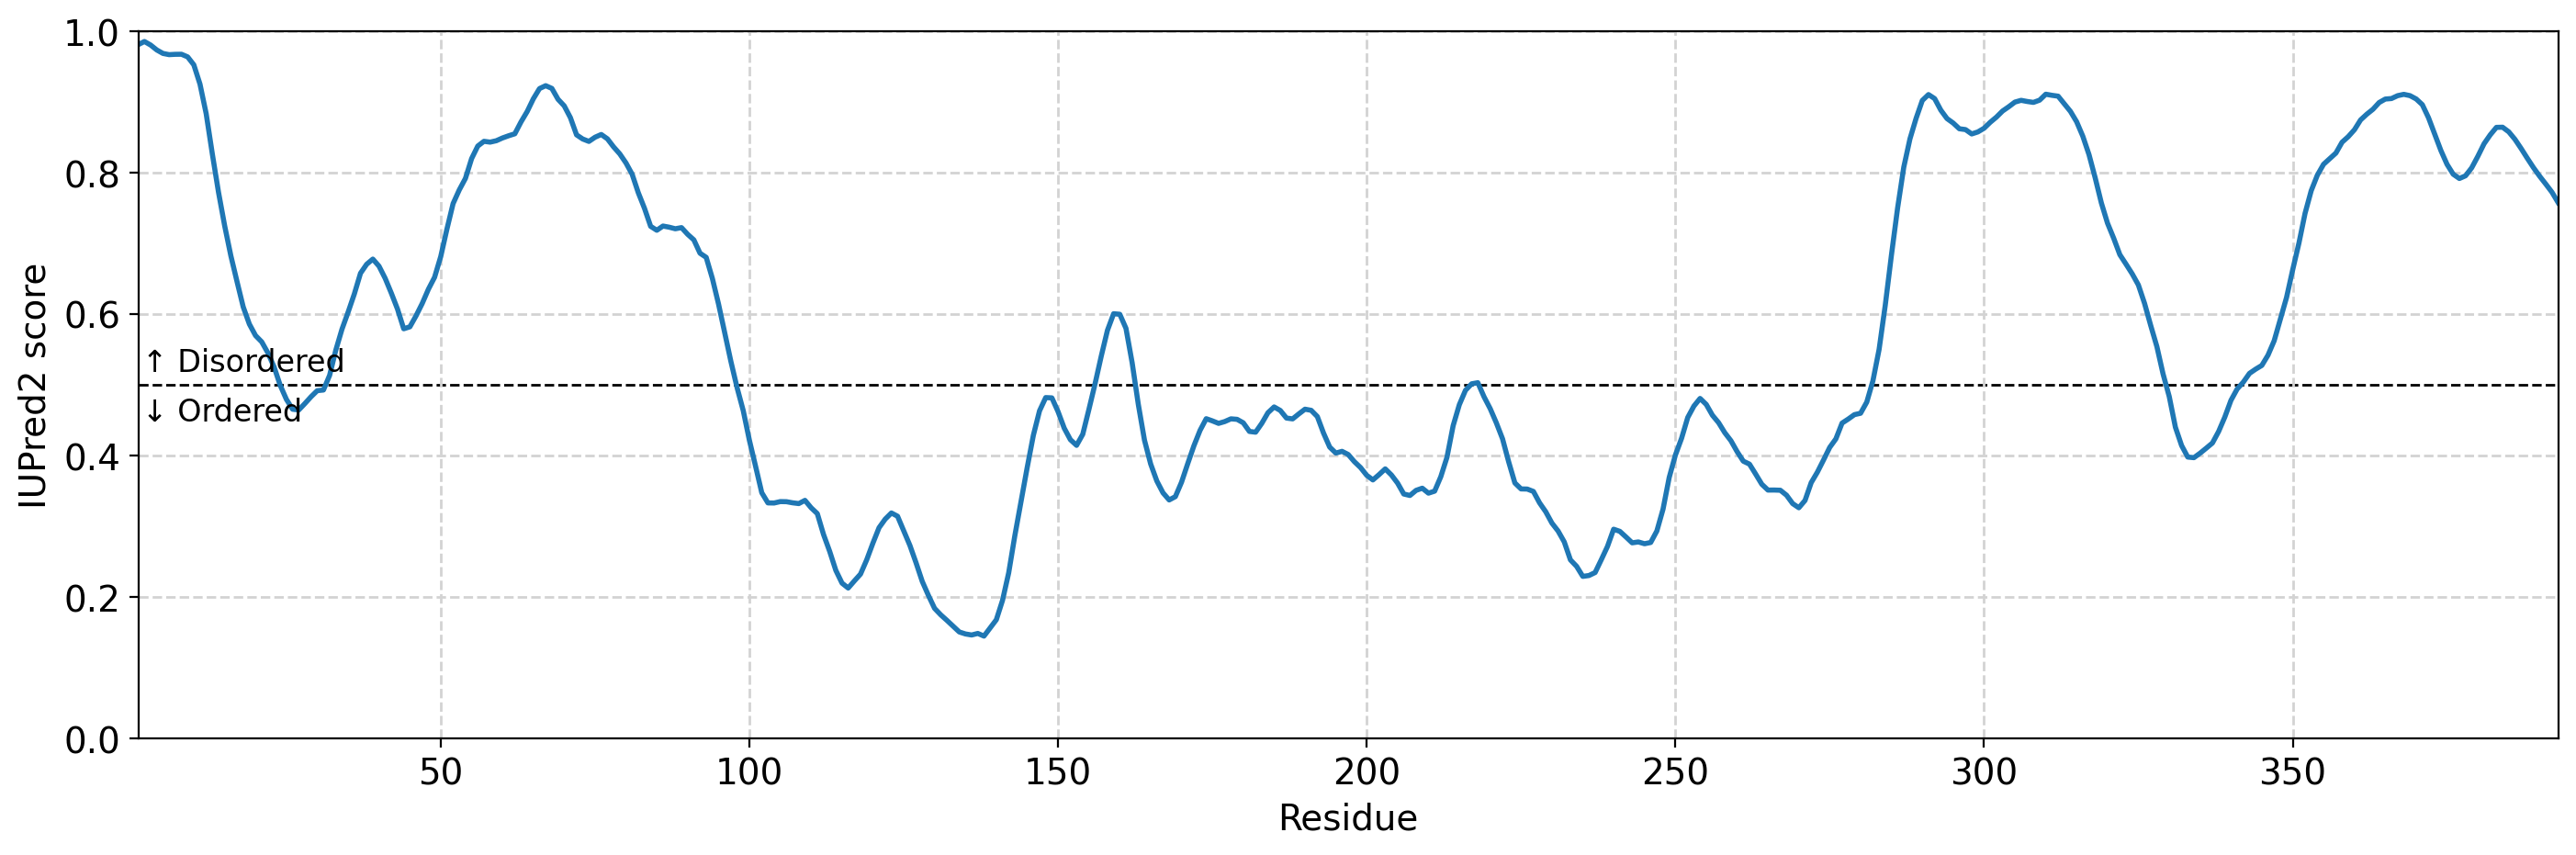

In [5]:
fig, ax = plt.subplots(figsize=(17,5))
fontsize = 14

# Plot IUPred2 scores returned by API
scores = r.json()["iupred2"]
ax.plot(np.arange(len(scores)+1)[1:], scores, lw=2)

# Set x and y axis labels
ax.set_xlabel("Residue", fontsize=fontsize)
ax.set_ylabel("IUPred2 score", fontsize=fontsize)

ax.axhline(0.5, color="black", lw=1, ls="--", zorder=-1)
ax.text(0, 0.52, " ↑ Disordered", fontsize=fontsize-2)
ax.text(0, 0.45, " ↓ Ordered", fontsize=fontsize-2)

ax.set_ylim(0,1)
ax.margins(x=0)
ax.tick_params(axis="both", labelsize=fontsize)
ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

fig.show()

Find putative ELMs for the UniProt Accession using `gget elm`:

In [6]:
ortho, regex = gget.elm(uniprot_acc, uniprot=True)

Filter the ELMs returned by `gget elm` based on the IUPred3 scores. In this example, we will filter the regex data frame for motifs in ordered protein regions by only keeping motifs for which each residue has a IUPred scored > 0.5.

In [7]:
# Get amino acid positions of all disordered residues (thresholded as IUPred score > 0.5)
disordered = np.arange(len(scores)+1)[1:][np.array(scores) > 0.5]

# Get amino acid positions of all ordered residues (thresholded as IUPred score < 0.5)
ordered = np.arange(len(scores)+1)[1:][np.array(scores) < 0.5]

In [8]:
def is_subset(arr1, arr2):
  """
  Function to check if an array (arr2) is a subset of anoter array (arr1).

  Rerturns True is arr2 is a subset of arr1.
  """
  m = len(arr1)
  n = len(arr2)
  s = set()
  for i in range(m):
      s.add(arr1[i])

  p = len(s)
  for i in range(n):
      s.add(arr2[i])

  if (len(s) == p):
    return True
  else:
    return False

In [9]:
# Categorize each motif based on the IUPred scores of its residues

iupred = []
for index, row in regex.iterrows():
  # Get the start and end amino acid positions of the motif
  start = row['motif_start_in_query']
  end = row['motif_end_in_query']

  # Check if all positions covered by the motif are within ordered or disordered IUPred scores thresholds
  if is_subset(ordered, list(range(start, end+1))):
    iupred.append("ordered")

  elif is_subset(disordered, list(range(start, end+1))):
    iupred.append("disordered")

  else:
    iupred.append("inbetween")

# Add IUPred categorization to the regex dataframe
regex["IUPred"] = iupred

In [10]:
# Only keey motifs that fall into ordered protein regions
regex[regex["IUPred"] == "ordered"]

,Instance_accession,ELMIdentifier,FunctionalSiteName,ELMType,Description,InteractionDomainId,InteractionDomainDescription,InteractionDomainName,Regex,Instances (Matched Sequence),motif_start_in_query,motif_end_in_query,InstanceLogic,#Instances,#Instances_in_PDB,IUPred
0,ELME000321,CLV_C14_Caspase3-7,Caspase cleavage motif,CLV,Caspase-3 and Caspase-7 cleavage site.,PF00656,Peptidase_C14,Caspase domain,[DSTE][^P][^DEWHFYC]D[GSAN],SDSDG,183,187,true positive,41,0,ordered
3,ELME000102,CLV_NRD_NRD_1,NRD cleavage site,CLV,N-Arg dibasic convertase (NRD/Nardilysin) clea...,PF00675,Peptidase_M16,Insulinase (Peptidase family M16),(.RK)|(RR[^KR]),RRC,174,176,true positive,2,0,ordered
4,ELME000102,CLV_NRD_NRD_1,NRD cleavage site,CLV,N-Arg dibasic convertase (NRD/Nardilysin) clea...,PF00675,Peptidase_M16,Insulinase (Peptidase family M16),(.RK)|(RR[^KR]),RRP,248,250,true positive,2,0,ordered
8,ELME000108,CLV_PCSK_KEX2_1,PCSK cleavage site,CLV,Yeast kexin 2 cleavage site (K-R-|-X or R-R-|-X).,PF00082,Peptidase_S8,Subtilase family,[KR]R.,RRC,174,176,true positive,1,0,ordered
9,ELME000108,CLV_PCSK_KEX2_1,PCSK cleavage site,CLV,Yeast kexin 2 cleavage site (K-R-|-X or R-R-|-X).,PF00082,Peptidase_S8,Subtilase family,[KR]R.,RRP,248,250,true positive,1,0,ordered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,ELME000012,TRG_ER_diArg_1,di Arginine retention/retrieving signal,TRG,The di-Arg ER retention motif is defined by tw...,PF00400,WD40,"WD domain, G-beta repeat","([LIVMFYWPR]R[^YFWDE]{0,1}R)|(R[^YFWDE]{0,1}R[...",VRR,173,175,true positive,27,0,ordered
185,ELME000012,TRG_ER_diArg_1,di Arginine retention/retrieving signal,TRG,The di-Arg ER retention motif is defined by tw...,PF00400,WD40,"WD domain, G-beta repeat","([LIVMFYWPR]R[^YFWDE]{0,1}R)|(R[^YFWDE]{0,1}R[...",RRP,248,250,true positive,27,0,ordered
186,ELME000012,TRG_ER_diArg_1,di Arginine retention/retrieving signal,TRG,The di-Arg ER retention motif is defined by tw...,PF00400,WD40,"WD domain, G-beta repeat","([LIVMFYWPR]R[^YFWDE]{0,1}R)|(R[^YFWDE]{0,1}R[...",IRGR,332,335,true positive,27,0,ordered
187,ELME000193,TRG_NES_CRM1_1,NES Nuclear Export Signals,TRG,Many proteins re-exported from the nucleus con...,PF08389,Xpo1,Exportin 1-like protein,"([DEQ].{0,1}[LIM].{2,3}[LIVMF][^P]{2,3}[LMVF]....",QHLIRVEGNLRVEYLD,192,207,true positive,18,3,ordered


**IUPred3 references:**

*Primary citations*

Gábor Erdős, Mátyás Pajkos, Zsuzsanna Dosztányi
IUPred3: prediction of protein disorder enhanced with unambiguous experimental annotation and visualization of evolutionary conservation
Nucleic Acids Research 2021;49(W1):W297-W303.

Bálint Mészáros, Gábor Erdős, Zsuzsanna Dosztányi
IUPred2A: context-dependent prediction of protein disorder as a function of redox state and protein binding
Nucleic Acids Research 2018;46(W1):W329-W337.

Gábor Erdős, Zsuzsanna Dosztányi
Analyzing Protein Disorder with IUPred2A
Current Protocols in Bioinformatics 2020;70(1):e99

*Additional citations*

Zsuzsanna Dosztányi
Prediction of protein disorder based on IUPred
Protein Science 2017;27:331-340.

Dosztányi Z, Csizmók V, Tompa P, Simon I.
The pairwise energy content estimated from amino acid composition discriminates between folded and intrinsically unstructured proteins
J Mol Biol. 2005;347:827-39.

Mészáros B, Simon I, Dosztányi Z.
Prediction of protein binding regions in disordered proteins
PLoS Comput Biol. 2009;5:e1000376.